In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfolio.timeseries import perf_stats

In [2]:
cash = 80000

read backtest results and generate daily returns dataframe

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-07-03_14-49_20190101_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
returns = df.cash.resample('B').last().pct_change().dropna()
returns.tail()

time
2019-12-24    0.015051
2019-12-25    0.000000
2019-12-26    0.059516
2019-12-27    0.116911
2019-12-30   -0.012663
Freq: B, Name: cash, dtype: float64

number of daily return data points:

In [5]:
len(df)

4302

In [6]:
returns.reset_index(drop=True, inplace=True)

# Generate random paths by resampling from returns (with replacements)

change this parameter to get different number of paths

In [7]:
number_of_paths = 500000

In [8]:
simulated_returns = pd.DataFrame(np.random.choice(returns, size=(len(returns), number_of_paths)))

In [9]:
simulated_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,499990,499991,499992,499993,499994,499995,499996,499997,499998,499999
0,-0.030790,-0.012768,0.172562,0.024843,0.011719,-0.022180,-0.019207,0.047670,0.057829,0.012999,...,-0.022180,0.048061,-0.012663,-0.006664,-0.015942,0.069512,0.015051,0.057829,0.048796,-0.019434
1,0.001874,0.004928,0.094154,0.010931,-0.028589,-0.014671,-0.019207,0.010931,0.002042,0.026831,...,0.106648,0.033024,-0.021238,-0.006253,-0.019338,0.000000,0.001336,0.009616,0.035686,0.018010
2,-0.015500,-0.024763,-0.027296,0.022758,0.046192,0.007598,-0.010937,0.044670,-0.008467,-0.045380,...,-0.051495,-0.006421,-0.009536,-0.014673,-0.006369,-0.023120,-0.015942,-0.005171,-0.024763,-0.027296
3,0.015308,0.007362,-0.022819,-0.009330,0.028958,-0.011397,0.022610,-0.006034,0.021300,0.017813,...,0.000000,0.010931,-0.015500,-0.013407,-0.007756,-0.011055,-0.000729,0.044670,0.029618,-0.030790
4,-0.036069,-0.006774,-0.011580,-0.020364,0.014687,-0.024246,-0.001315,-0.000601,-0.019070,0.015852,...,-0.006369,0.024334,-0.023640,-0.026986,0.063013,-0.007177,0.128198,-0.014671,0.048796,0.172562


# Quick visual on actual vs. simulated distribution

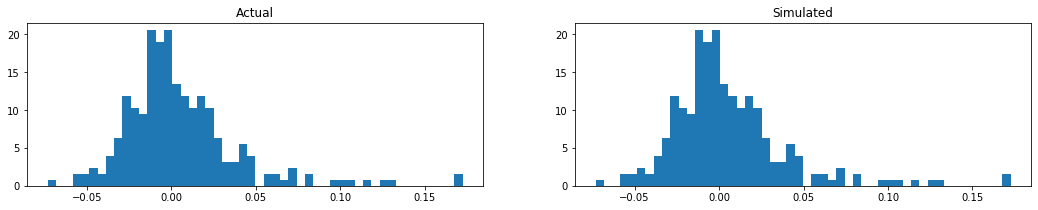

In [10]:
fig = plt.figure(figsize=(18,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.hist(returns, bins=50, density=True)
ax2.hist(simulated_returns.values.flatten(), bins=50, density=True)
ax1.set_title('Actual')
ax2.set_title('Simulated')
plt.show();

# Stats for actual returns

In [11]:
a=perf_stats(returns)
a

Annual return           2.332382
Cumulative returns      2.429267
Annual volatility       0.540298
Sharpe ratio            2.491541
Calmar ratio           15.038590
Stability               0.919913
Max drawdown           -0.155093
Omega ratio             1.601827
Sortino ratio           5.358079
Skew                    1.717213
Kurtosis                5.224945
Tail ratio              1.830008
Daily value at risk    -0.062729
dtype: float64

# Stats for simulated returns (median, max, min)

In [12]:
ratios_for_paths = pd.DataFrame([perf_stats(x[1]) for x in simulated_returns.T.iterrows()])

median

In [13]:
ratios_for_paths.median().T

Annual return           2.303582
Cumulative returns      2.398928
Annual volatility       0.536748
Sharpe ratio            2.490762
Calmar ratio           10.050636
Stability               0.883389
Max drawdown           -0.229511
Omega ratio             1.598669
Sortino ratio           5.339955
Skew                    1.676800
Kurtosis                4.913819
Tail ratio              1.863861
Daily value at risk    -0.062317
dtype: float64

max

In [14]:
ratios_for_paths.max().T

Annual return           50.620767
Cumulative returns      55.702994
Annual volatility        0.738878
Sharpe ratio             6.083865
Calmar ratio           351.449989
Stability                0.994430
Max drawdown            -0.074067
Omega ratio              3.667069
Sortino ratio           21.663811
Skew                     2.906604
Kurtosis                12.714776
Tail ratio               4.484198
Daily value at risk     -0.041808
dtype: float64

min

In [15]:
ratios_for_paths.min().T

Annual return         -6.452782e-01
Cumulative returns    -6.539244e-01
Annual volatility      3.489159e-01
Sharpe ratio          -2.066968e+00
Calmar ratio          -9.852672e-01
Stability              3.791750e-10
Max drawdown          -7.580564e-01
Omega ratio            6.992299e-01
Sortino ratio         -3.086427e+00
Skew                  -1.588768e-02
Kurtosis              -5.467022e-03
Tail ratio             6.555684e-01
Daily value at risk   -8.266869e-02
dtype: float64

# Probability that max drawdown less than x

In [24]:
x = -.35
len(ratios_for_paths[ratios_for_paths['Max drawdown'] < x]) / number_of_paths

0.08431

# Probability that Sharpe lower than y

In [17]:
y = 1
len(ratios_for_paths[ratios_for_paths['Sharpe ratio'] < y]) / number_of_paths

0.052006

# Probability that annual return less than z

In [18]:
z = .5
len(ratios_for_paths[ratios_for_paths['Annual return'] < z]) / number_of_paths

0.058408

# Distributions

Max drawdown

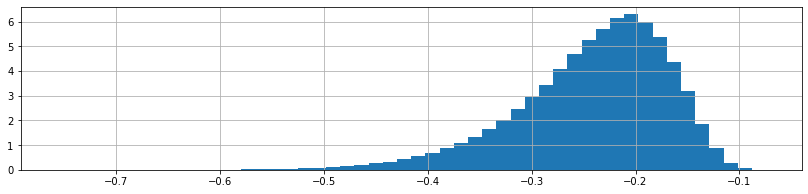

In [19]:
ratios_for_paths['Max drawdown'].hist(bins=50, figsize=(14,3), density=True);

Sharpe

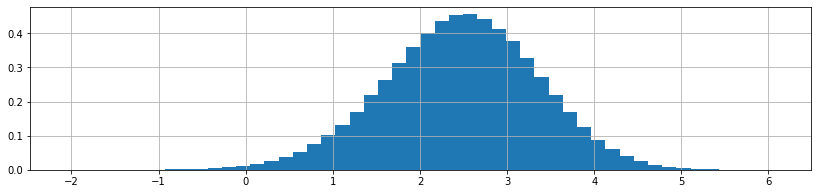

In [20]:
ratios_for_paths['Sharpe ratio'].hist(bins=50, figsize=(14,3), density=True);

Annual return

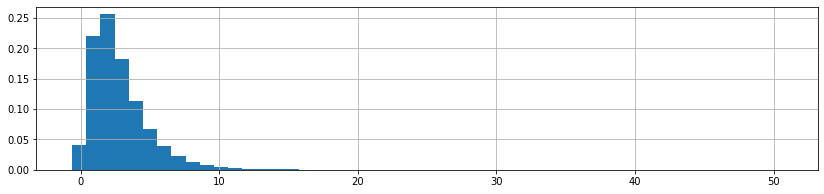

In [21]:
ratios_for_paths['Annual return'].hist(bins=50, figsize=(14,3), density=True);